In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import os
import platform
from subprocess import check_output
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

In [10]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

In [11]:
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [13]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = r'C:\Users\Pegah Khazaie\Desktop\cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255
    return x_train, y_train, X_val, y_val, x_test, y_test
# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()

In [14]:
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [16]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [17]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [18]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


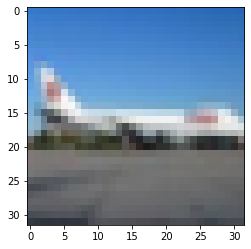

In [20]:
batch_id = 3
sample_id = 7000
display_stats(r'C:\Users\Pegah Khazaie\Desktop\cifar-10-batches-py/', batch_id, sample_id)


In [21]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [22]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [23]:

def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [26]:
preprocess_and_save_data(r'C:\Users\Pegah Khazaie\Desktop\cifar-10-batches-py/', normalize, one_hot_encode)

In [27]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [28]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [29]:

import tensorflow as tf

def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out

In [31]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

In [32]:

logits = conv_net(x, keep_prob)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [33]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

In [34]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [35]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [36]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1756 Validation Accuracy: 0.192400
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.8448 Validation Accuracy: 0.238600
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.5965 Validation Accuracy: 0.285000
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.5628 Validation Accuracy: 0.364400
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.3624 Validation Accuracy: 0.393000
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.4931 Validation Accuracy: 0.384200
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.3099 Validation Accuracy: 0.489800
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.0453 Validation Accuracy: 0.509400
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.0830 Validation Accuracy: 0.562000
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.9156 Validation Accuracy: 0.597600
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.8750 Validation Accuracy: 0.615000
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.6971 Validation Accuracy: 0.624200
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.6684 Validation Accuracy: 0.628600
